# 25th July - Forget it, let's just use James' networks

Try and get some simple RNNs to do interensting things

In [818]:
import torch
import parameters_will
import torch.optim as optim
import RNN_Will as _model_
import numpy as np
import matplotlib.pyplot as plt
import pickle

%load_ext autoreload
%autoreload 2

# Set up our parameters
params = parameters_will.default_params()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [819]:
def generate_data(params):
    trial_len = params.data.min_length + np.random.randint(params.data.max_length - params.data.min_length)
    number_of_beats = params.data.min_beats + np.random.randint(params.data.max_beats - params.data.min_beats)
    if params.data.freq_type == 0:
        freqs = params.data.min_freq + np.random.randint(params.data.max_freq-params.data.min_freq, size=[params.data.batch_size])
    else:
        freqs = np.random.choice(params.data.freqs, size = params.data.batch_size)
    jitter = np.random.randint(freqs)
    
    output_traces = np.zeros([trial_len, params.data.batch_size])
    input_traces = np.zeros([trial_len, params.data.batch_size])
    input_or_rnn = np.zeros([trial_len, params.data.batch_size])
    
    for (freq_ind, freq) in enumerate(freqs):
        number_of_predictions = int(np.floor((trial_len-1-params.data.offset-jitter[freq_ind])/freq+1))
        if params.data.data_type == 0:
            output_traces[freq*np.arange(number_of_predictions) + jitter[freq_ind]+params.data.offset, freq_ind] = 1
            input_traces[freq*np.arange(min(number_of_beats,number_of_predictions) ) + jitter[freq_ind], freq_ind] = 1
        elif params.data.data_type == 1:
            output_traces[:, freq_ind] = np.cos(np.arange(trial_len)*2*np.pi/freq + jitter[freq_ind][freq_ind])
            input_traces[:freq*number_of_beats, freq_ind] = np.cos(np.arange(freq*params.data.number_of_beats)*2*np.pi/freq + jitter[freq_ind])
        input_or_rnn[:freq*number_of_beats,freq_ind] = 1
        #input_or_rnn[:,:] = 1
        
    input_dict = parameters_will.DotDict()
    input_dict.observation = torch.from_numpy(input_traces).type(torch.float32)
    input_dict.outputs = torch.from_numpy(output_traces).type(torch.float32)
    input_dict.input_or_rnn = torch.from_numpy(input_or_rnn).type(torch.float32)
    
    params.model.seq_len = trial_len
    
    return input_dict

Text(0.5, 1.0, 'RNN or Not')

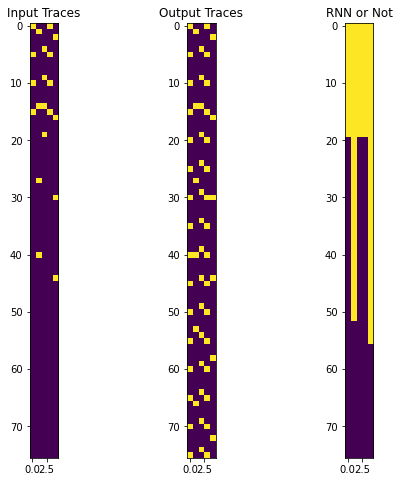

In [820]:
input_dict = generate_data(params)
plt.figure(figsize = (8,8))
plt.subplot(1,3,1)
plt.imshow(input_dict.observation)
plt.title('Input Traces')

plt.subplot(1,3,2)
plt.imshow(input_dict.outputs)
plt.title('Output Traces')

plt.subplot(1,3,3)
plt.imshow(input_dict.input_or_rnn)
plt.title('RNN or Not')

In [821]:
params.train.train_iters = 1000000
print_iters = 100
reinitialise = 1

if reinitialise:
    # make instance of model
    model = _model_.VanillaRNN(params.model)
    # put model to gpu (if available)
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)

    # Make an ADAM optimizer
    optimizer = optim.Adam(model.parameters(), lr=params.train.learning_rate, weight_decay=params.train.weight_decay)
else:
    model.batch_size = params.data.batch_size

min_loss = np.infty

for train_i in range(params.train.train_iters):

    # 1. Get input data, and convert to tensors (I have assumed you will put inputs etc into a dictionary)
    input_dict = generate_data(params)
    
    # set all gradients to None
    # optimizer.zero_grad()
    for param in model.parameters():
        param.grad = None
        
    # forward pass
    variables = model(input_dict, device=device)
    
    # collate inputs for model
    (losses, loss_fit) = _model_.compute_losses_torch(input_dict, variables, model, params.train, device=device)

    # backward pass
    losses.backward()

    # clip gradients (you don't have to do this but it's a good idea for RNNs)
    torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=2.0, norm_type=2)

    optimizer.step()
    
    if losses.detach() < min_loss:
        min_loss = losses.detach()
        best_model = model
        print(f"{train_i}, new PB! {min_loss}")

    if train_i % print_iters == 0:
        print(f"{train_i}, {losses.item():.5f}, {loss_fit.item():.5f}, {losses.item()-loss_fit.item():.5f}")

0, new PB! 1437.041748046875
0, 1437.04175, 579.88684, 857.15491
1, new PB! 529.9111328125
5, new PB! 508.5352783203125
10, new PB! 140.6123504638672
22, new PB! 91.5957260131836
54, new PB! 86.23421478271484
60, new PB! 64.29212951660156
70, new PB! 53.309547424316406
88, new PB! 44.255313873291016
100, 86.67804, 47.03599, 39.64205
110, new PB! 41.73768615722656
133, new PB! 35.00691223144531
145, new PB! 30.137088775634766
151, new PB! 29.121814727783203
158, new PB! 27.813793182373047
164, new PB! 27.098634719848633
200, 182.35504, 155.81903, 26.53601
247, new PB! 26.0189151763916
287, new PB! 24.93976593017578
288, new PB! 15.98546314239502
300, 48.00740, 31.42620, 16.58120
400, 50.62398, 41.48880, 9.13517
493, new PB! 13.488950729370117
500, 133.27310, 124.07771, 9.19539
537, new PB! 11.466347694396973
600, 39.80242, 29.26818, 10.53425
700, 46.29311, 38.02655, 8.26657
794, new PB! 8.177209854125977
800, 103.22285, 92.95831, 10.26455
900, 74.95717, 65.29491, 9.66226
1000, 105.16796

KeyboardInterrupt: 

In [822]:
params.data.freqs

[5, 6, 7, 8, 9, 11, 12, 13, 14, 15]

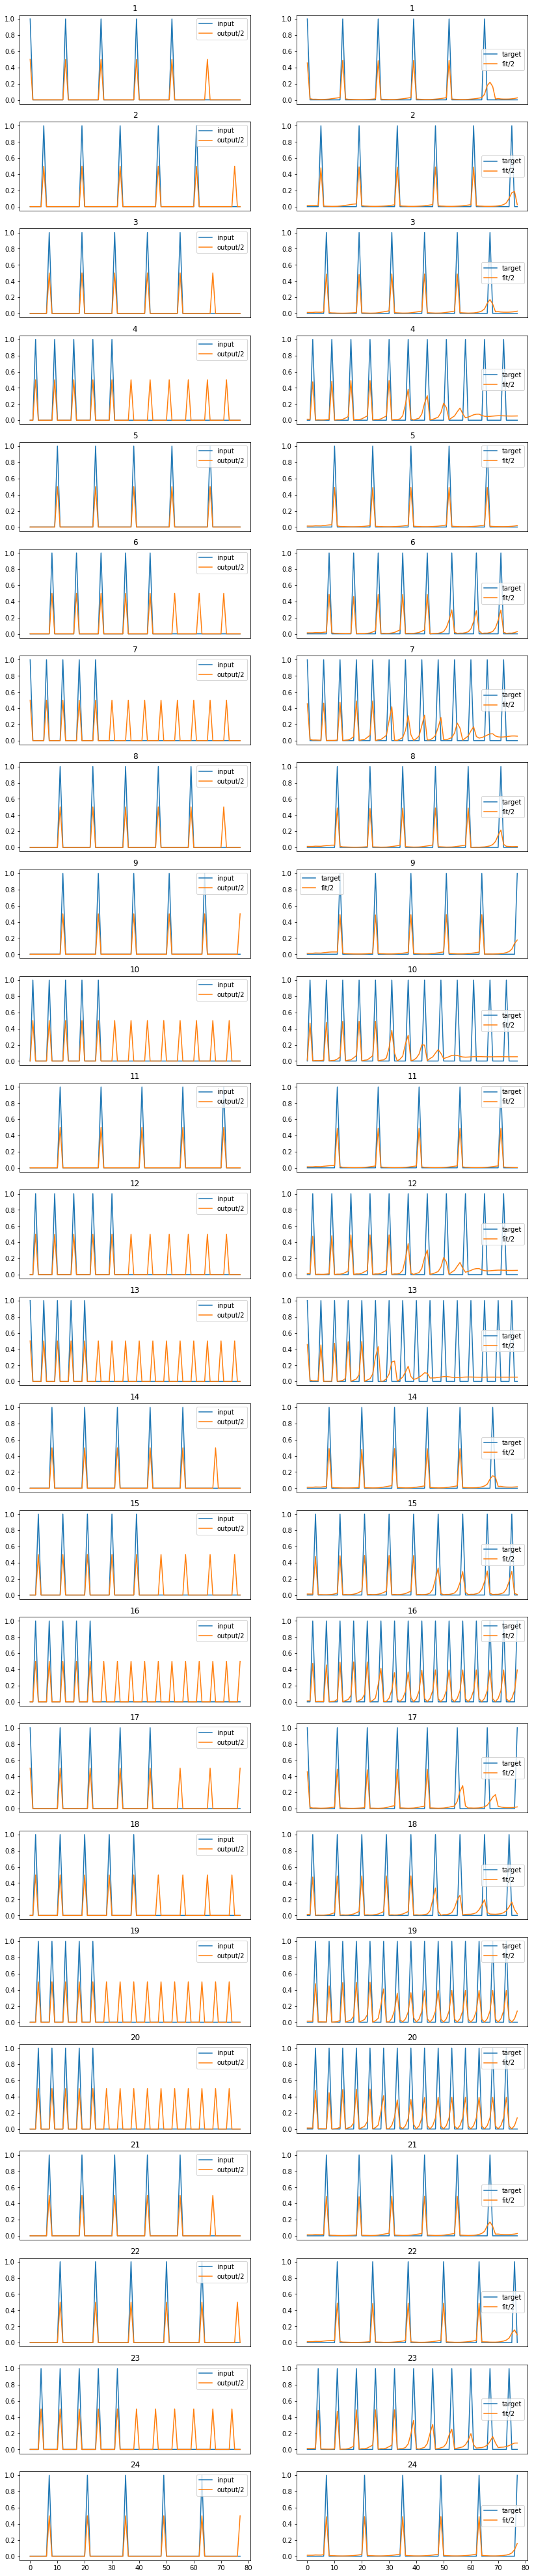

In [823]:
# Let's have a look at how one example is going
use_best = 1
if use_best:
    model_use = best_model
else:
    model_use = model
    
freq_given = 1
if freq_given:
    params.data.freq_type = 1
    freqs = np.arange(1, 25)
    params.data.batch_size = len(freqs)
    plot_batch_size = len(freqs)
    model.batch_size = params.data.batch_size
    input_dict = generate_data(params)
    titles = freqs
else:
    params.data.freq_type = 0
    plot_batch_size = params.data.batch_size
    input_dict = generate_data(params)
    titles = []

variables = model_use(input_dict, device=device)
output = torch.stack(variables.pred)
plt.figure(figsize=(14,3*params.data.batch_size))

for sample in range(plot_batch_size):
    plt.subplot(plot_batch_size,2,1+sample*2)
    #plt.title(f'Desired Function, freq = {params.data.freqs[sample]}')
    plt.plot(input_dict.observation[:,sample],label='input')
    plt.plot(0.5*input_dict.outputs[:,sample],label='output/2')
    plt.legend()
    if len(titles) > 0:
        plt.title(titles[sample])
    if sample < plot_batch_size-1:
        plt.xticks([])
        
    plt.subplot(plot_batch_size,2,2+sample*2)
    #plt.title(f'Network Behaviour, freq = {params.data.freqs[sample]}')
    plt.plot(input_dict.outputs[:,sample], label='target')
    plt.plot(0.5*output.detach().numpy()[:,sample,0], label = 'fit/2')
    plt.legend()
    if len(titles) > 0:
        plt.title(titles[sample])
    if sample < plot_batch_size-1:
        plt.xticks([])
params = parameters_will.default_params()

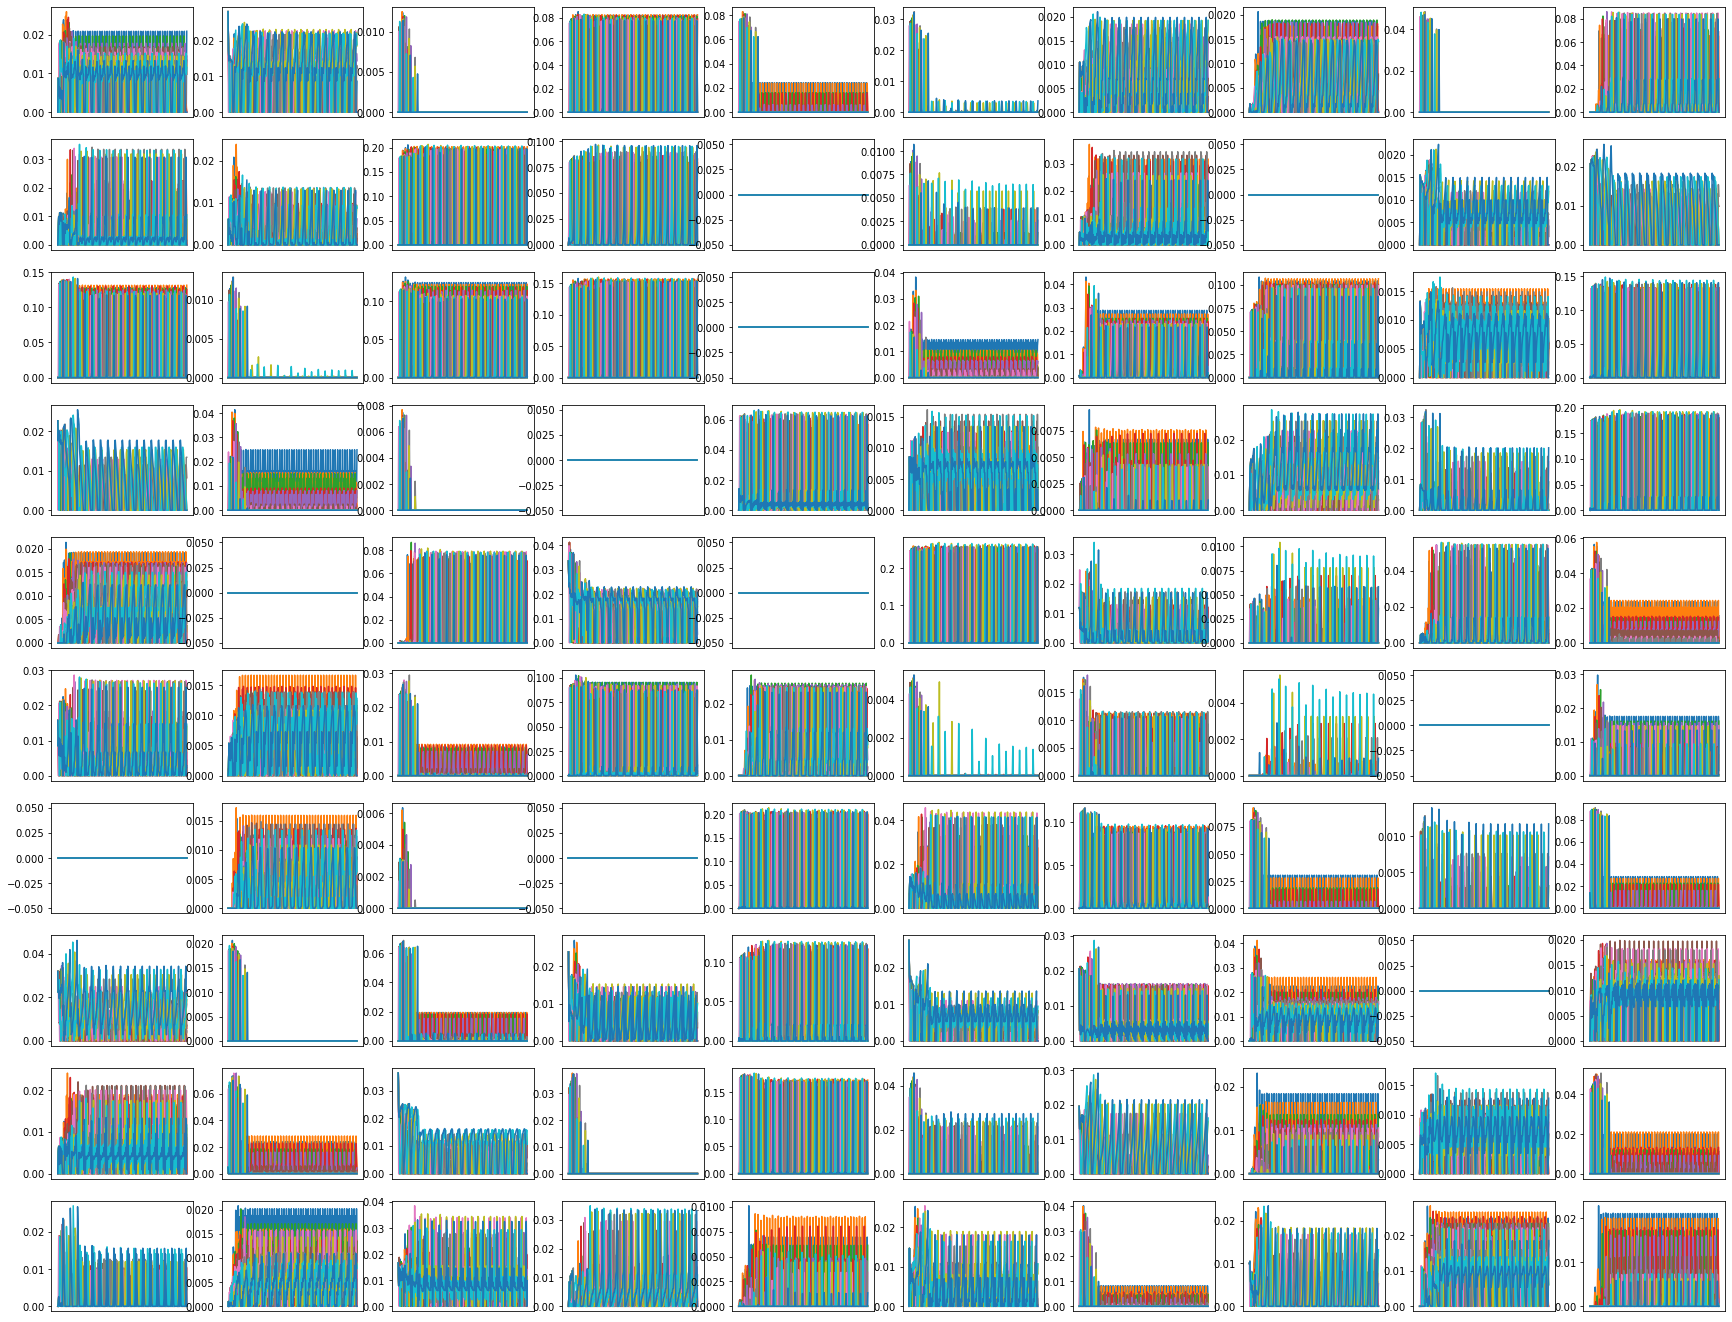

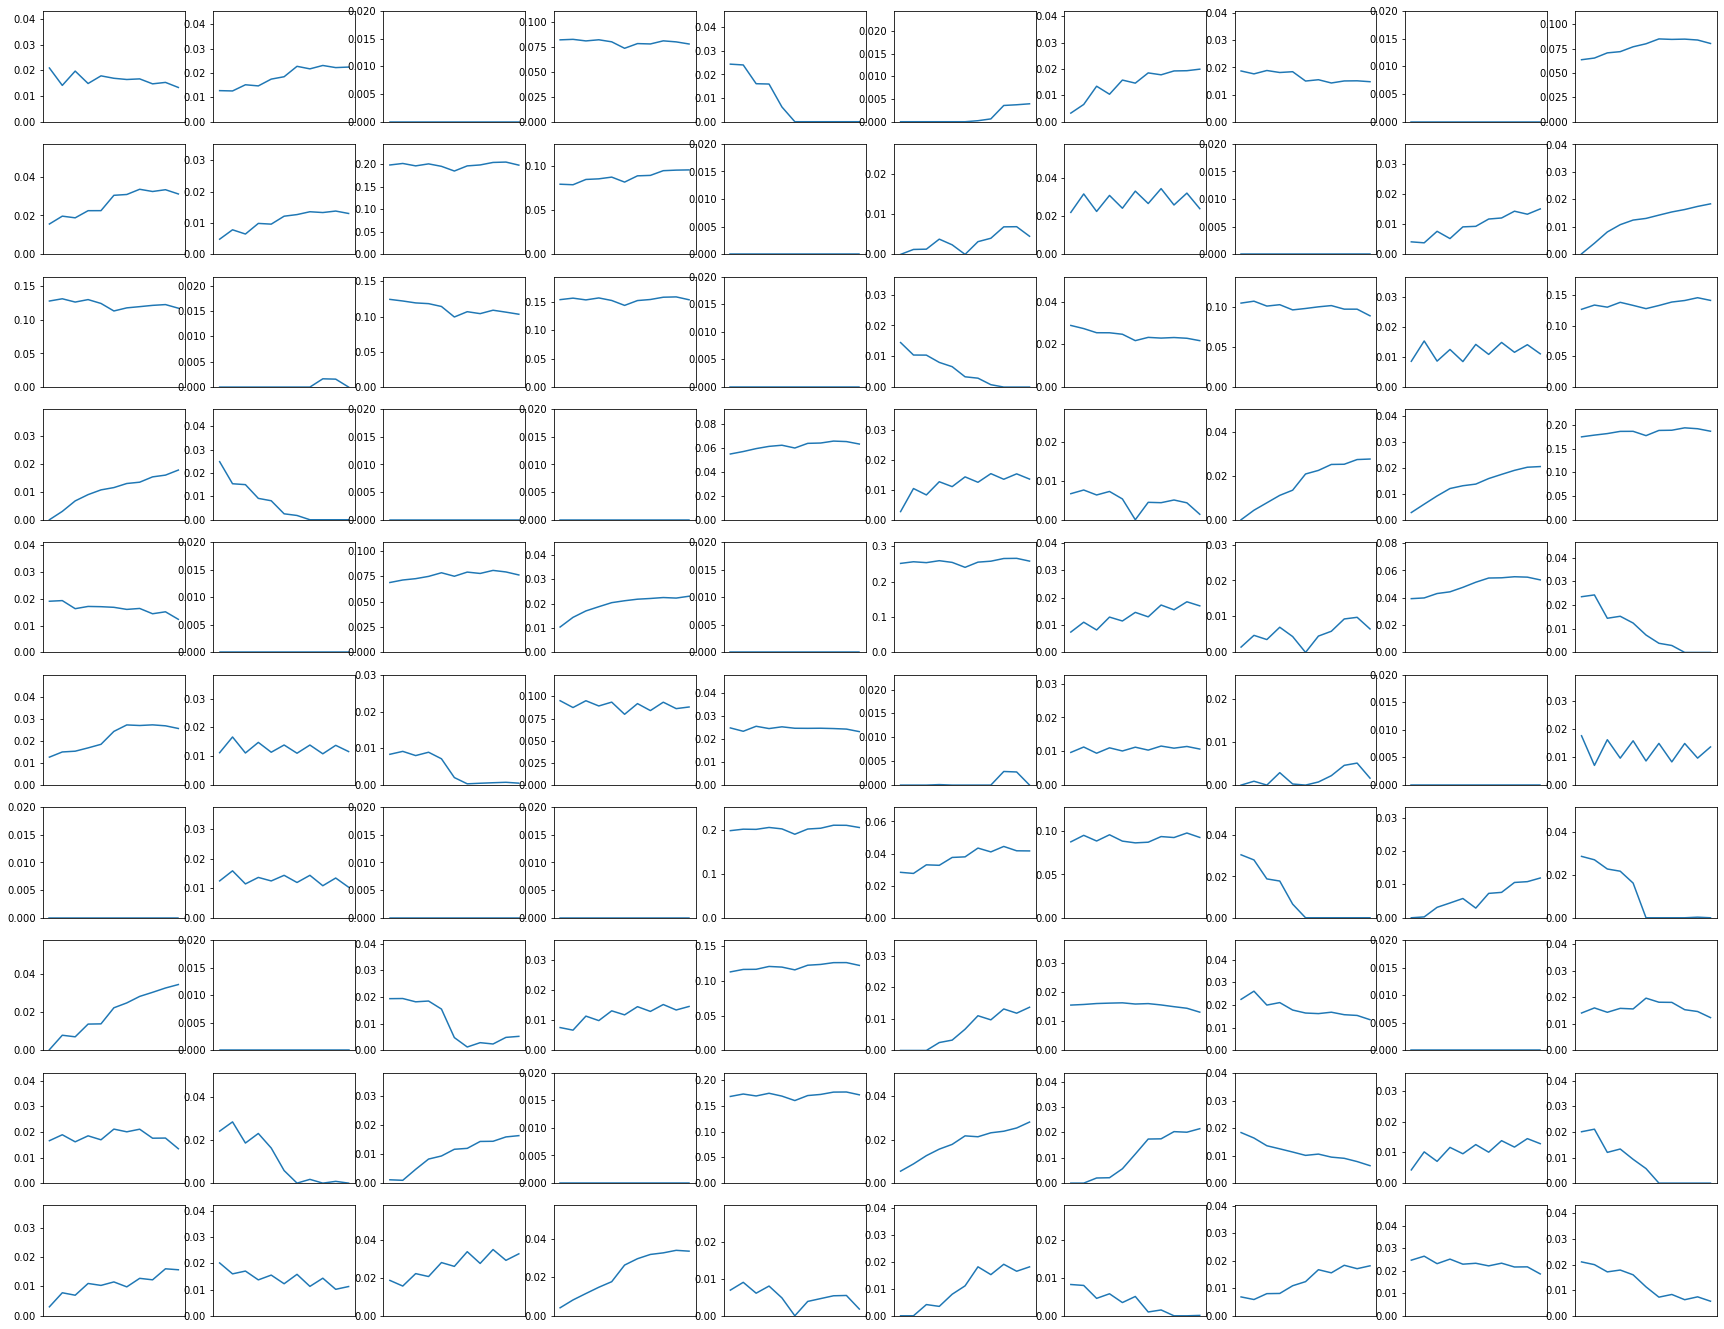

In [785]:
# Now looks we'll look at the network activities
num_plots_sqrt = 10
hidden_activities = torch.stack(variables.hidden).detach().numpy()
plt.figure(figsize = (30,24))

cutoff = 80
peak_activity = np.zeros([params.model.h_size, plot_batch_size])
model_use.batch_size = plot_batch_size

for neuron in range(params.model.h_size):
    plt.subplot(num_plots_sqrt, num_plots_sqrt, neuron+1)
    plt.plot(hidden_activities[:,:,neuron])
    plt.xticks([])
    #plt.yticks([])
    
    peak_activity[neuron,:] = np.max(hidden_activities[cutoff:,:,neuron], axis = 0)
    
plt.figure(figsize = (30,24))
for neuron in range(params.model.h_size):
    plt.subplot(num_plots_sqrt, num_plots_sqrt, neuron+1)
    plt.plot(peak_activity[neuron,:])
    plt.xticks([])
    plt.ylim([0, max(peak_activity[neuron,:])*1.1+0.02])
    #plt.yticks([])
    
model_use.batch_size = params.model.batch_size
params = parameters_will.default_params()

In [737]:
# Now test it on heldout frequencies
heldout_freqs = [i + 3 for i in params.data.freqs]
# heldout_freqs = [10]
# heldout_freqs = params.data.freqs
params.data.number_of_beats = 6
total_len_heldout = np.max(heldout_freqs)*(params.data.number_of_beats + params.data.minimal_number_of_pred)
params.model.batch_size = len(heldout_freqs)
model.batch_size = len(heldout_freqs)

output_traces_heldout = np.zeros([total_len_heldout, np.sum(heldout_freqs)])
input_traces_heldout = np.zeros([total_len_heldout, np.sum(heldout_freqs)])
input_or_rnn_heldout = np.zeros([total_len_heldout, np.sum(heldout_freqs)])

counter = 0
for freq in heldout_freqs:
    for jitter in range(freq):
        number_of_predictions = int(np.floor((total_len_heldout-2-jitter)/freq+1))
        #print((number_of_predictions-1)*freq + jitter)
        output_traces_heldout[freq*np.arange(number_of_predictions) + jitter+1, counter] = 1
        input_traces_heldout[freq*np.arange(params.data.number_of_beats) + jitter, counter] = 1
        input_or_rnn_heldout[:freq*(params.data.number_of_beats),counter] = 1
        counter+=1
        
output_traces_heldout = output_traces_heldout[:,:total_len]
input_traces_heldout = input_traces_heldout[:,:total_len]
input_or_rnn_heldout = input_or_rnn_heldout[:,:total_len]

plt.figure(figsize = (8,8))
plt.subplot(1,3,1)
plt.imshow(input_traces_heldout)
plt.title('Input Traces')

plt.subplot(1,3,2)
plt.imshow(output_traces_heldout)
plt.title('Output Traces')

plt.subplot(1,3,3)
plt.imshow(input_or_rnn_heldout)
plt.title('RNN or Not')



AttributeError: 'DotDict' object has no attribute 'minimal_number_of_pred'

In [359]:
offset_markers = [sum(heldout_freqs[:i]) for i in range(len(heldout_freqs))]
data_ids = np.random.randint(heldout_freqs) + offset_markers
input_dict.observation = torch.from_numpy(input_traces_heldout[:,data_ids]).type(torch.float32)
input_dict.input_or_rnn = torch.from_numpy(input_or_rnn_heldout[:,data_ids]).type(torch.float32)
input_dict.outputs = torch.from_numpy(output_traces_heldout[:,data_ids]).type(torch.float32)

# forward pass
variables = model(input_dict, device=device)

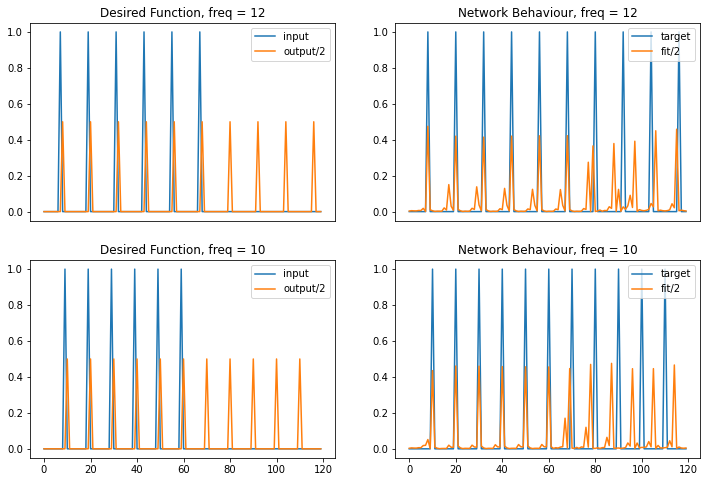

In [360]:
# Let's have a look at how one example is going
output = torch.stack(variables.pred)
plt.figure(figsize=(12,4*len(heldout_freqs)))

for sample in range(len(heldout_freqs)):
    plt.subplot(len(heldout_freqs),2,1+sample*2)
    plt.title(f'Desired Function, freq = {heldout_freqs[sample]}')
    plt.plot(input_dict.observation[:,sample],label='input')
    plt.plot(0.5*input_dict.outputs[:,sample],label='output/2')
    plt.legend()
    if sample < len(heldout_freqs)-1:
        plt.xticks([])

    plt.subplot(len(heldout_freqs),2,2+sample*2)
    plt.title(f'Network Behaviour, freq = {heldout_freqs[sample]}')
    plt.plot(input_dict.outputs[:,sample], label='target')
    plt.plot(0.5*output.detach().numpy()[:,sample,0], label = 'fit/2')
    plt.legend()
    if sample < len(heldout_freqs)-1:
        plt.xticks([])

In [361]:
model

VanillaRNN(
  (activation): ReLU()
  (out_activation): Sigmoid()
  (transition): Linear(in_features=100, out_features=100, bias=True)
  (embedding): Linear(in_features=1, out_features=100, bias=True)
  (predict): Linear(in_features=100, out_features=1, bias=True)
)

In [786]:
path = '/Users/will/Documents/Inverse_Models/Periodic_RNNs/James_Network/'
name = 'winnerx'
path_name = path + name

In [787]:
torch.save(model, path_name)

In [319]:
#input_to_hidden = inputs.observation.reshape((-1, self.par.i_size)).reshape((self.seq_len, self.batch_size, -1))
model = _model_.VanillaRNN(params.model)
offset_markers = [sum(params.data.freqs[:i]) for i in range(len(params.data.freqs))]
data_ids = np.random.randint(params.data.freqs) + offset_markers
input_dict.observation = torch.from_numpy(input_traces[:,data_ids]).type(torch.float32)
input_dict.input_or_rnn = torch.from_numpy(input_or_rnn[:,data_ids]).type(torch.float32)
input_dict.outputs = torch.from_numpy(output_traces[:,data_ids]).type(torch.float32)

inputs = input_dict

# initialise hidden
h = model.activation(model.hidden_init.tile([model.batch_size, 1]))  # (can remove activation here)
pred = model.predict(h)
hs, preds = [], []

# Run RNN
for i, (i_to_h) in enumerate(input_dict.observation):
    # this is your thing to gate the input (you need to specify inputs.input_or_rnn which is batch x seq_len x 1
    hidden_input = inputs.input_or_rnn[i,][:,None] * model.embedding(i_to_h[:,None]) + (1.0 - inputs.input_or_rnn[i,:][:,None]) *  model.embedding(pred)
    # path integrate (generative)
    h = model.activation(model.transition(h) + hidden_input)
    # store rnn hidden states
    hs.append(h)

    # prediction (this makes a prediction for next time-step (can add activation post transition if you want))
    pred = model.out_activation(model.predict(h))
    # store rnn hidden states
    preds.append(pred)

In [153]:
torch.sum(torch.pow(torch.stack(variables.hidden), 2))

tensor(266799.0625, grad_fn=<SumBackward0>)

In [150]:
torch.stack(variables.hidden).shape

torch.Size([84, 4, 100])